<a href="https://colab.research.google.com/github/allarva/itmo_course/blob/main/my_metrics1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U scikit-learn > None # Restart environment after
!pip install --upgrade matplotlib > None # need refresh enviroment after installation

In [2]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_squared_error, classification_report, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.dummy import DummyRegressor

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Data intro

Набор данных состоит из 1000 записей, содержащих пол, расу, уровень образования родителей, ланч, наличие курса подготовки, оценку математики, чтения и письма.

Построение модели линейной регрессии с целевым признаком math score, т.е. исследование влияния показателей на уровень оценки по математике.

In [3]:
data = pd.read_csv('exams.csv')
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


In [4]:
data.columns #наименования признаков

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [5]:
data.dtypes #тип данных

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

In [6]:
data.isna().sum() #количество пустых ячеек по колонкам

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [7]:
df = data.copy().dropna() # удаляет данные с пустыми ячейками, здесь их нет, строка не нужна

# Работа с категориальными признаками

In [8]:
col_string = ['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course']
for col in data[col_string]: 
    print(f'Column = {col}\nElements = {data[col].unique()}\n')
#значения катеогриальных признаков

Column = gender
Elements = ['male' 'female']

Column = race/ethnicity
Elements = ['group A' 'group D' 'group E' 'group B' 'group C']

Column = parental level of education
Elements = ['high school' 'some high school' 'some college' "associate's degree"
 "bachelor's degree" "master's degree"]

Column = lunch
Elements = ['standard' 'free/reduced']

Column = test preparation course
Elements = ['completed' 'none']



In [9]:
cat_cols = df.select_dtypes(include='object') #выбор категориалььных признаков
cat_cols.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course
0,male,group A,high school,standard,completed
1,female,group D,some high school,free/reduced,none
2,male,group E,some college,free/reduced,none
3,male,group B,high school,standard,none
4,male,group E,associate's degree,standard,completed


In [10]:
cat_cols.shape

(1000, 5)

In [11]:
cat_cols.describe()

,gender,race/ethnicity,parental level of education,lunch,test preparation course
count,1000,1000,1000,1000,1000
unique,2,5,6,2,2
top,male,group C,some college,standard,none
freq,517,323,222,652,665


## Try label encoding

Замену делаю с помощью replace, поскольку для некоторых категорий определенным значениям полезно присвоить определенное числовое значение, чтобы показать взаимосвязь. Например, для parental level of education значения целесообразно упорядочить от низкого уровня к высокому (0--4). Признаки gender, lunch, test preparation course имеют по два значения, поэтому уместна двоичная кодировка

In [12]:
cleanup_nums = {"gender":     {"male": 0, "female": 1},
                "race/ethnicity": {"group A": 0, "group B": 1, "group C": 2, "group D": 3,
                                  "group E": 4},
                "parental level of education": {"some high school": 0, "high school": 1, "some college": 2, "associate's degree": 3,
                                  "bachelor's degree": 4 , "master's degree": 5},
                "lunch":     {"standard": 0, "free/reduced": 1},
                "test preparation course":     {"none": 0, "completed": 1}}
df = df.replace(cleanup_nums)
df.head()  

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,0,0,1,0,1,67,67,63
1,1,3,0,1,0,40,59,55
2,0,4,2,1,0,59,60,50
3,0,1,1,0,0,77,78,68
4,0,4,3,0,1,78,73,68


## Исключение мультиколлениарности
Выявление мультиколлинеарности — наличия линейной зависимости между объясняющими переменными (факторами) регрессионной модели. 
Удаление сильно коррелирующих признаков, чтобы избежать переобученности модели и больших стандартных ошибок.

In [13]:
corrs = df.corr()
upper_tri = corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(np.bool))
upper_tri

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
gender,NaN,-0.063231,-0.016830,-0.033962,-0.007653,-0.200863,0.189389,0.246089
race/ethnicity,NaN,NaN,-0.057522,0.033335,-0.029828,0.213156,0.131459,0.133955
parental level of education,NaN,NaN,NaN,-0.016037,0.013075,0.229113,0.224410,0.267894
lunch,NaN,NaN,NaN,NaN,-0.029267,-0.374431,-0.288282,-0.319191
test preparation course,NaN,NaN,NaN,NaN,NaN,0.151704,0.245144,0.315601
math score,NaN,NaN,NaN,NaN,NaN,NaN,0.819398,0.805944
reading score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.954274
writing score,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


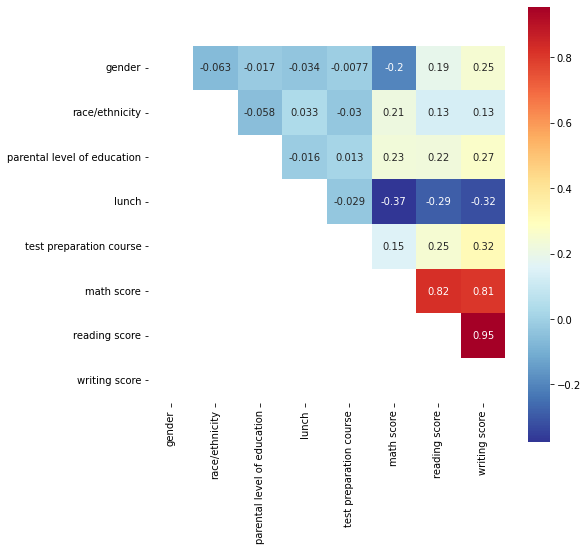

In [14]:
plt.figure(figsize=(8, 8))
sns.heatmap(upper_tri, cmap="RdYlBu_r", square=True, annot=True);

In [15]:
cols_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
cols_to_drop
#выявление признаков с корреляцией больше 0,95

['writing score']

In [16]:
cutted_df = df.drop(columns=cols_to_drop)#удаление признаков с корреляцией больше 0,95
cutted_df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score
0,0,0,1,0,1,67,67
1,1,3,0,1,0,40,59
2,0,4,2,1,0,59,60
3,0,1,1,0,0,77,78
4,0,4,3,0,1,78,73


# Train-test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    cutted_df.drop(columns='math score'),
    cutted_df['math score'], 
    random_state=2023, 
    test_size=0.25
)

In [18]:
X_train.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score
330,0,2,2,0,0,69
859,1,3,1,0,1,84
596,1,1,1,1,1,85
480,1,1,0,0,0,88
553,0,4,5,1,0,62


# Обучение

In [19]:
dummy = DummyRegressor(strategy='median')#константное предсказание (медиана)
dummy.fit(X_train, y_train)
y_preds_dummy = dummy.predict(X_test)

In [20]:
lr = LinearRegression()#бейзлайновая модель (линейная регрессия)
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)

# Выбор метрики
Выбранные метрики: RMSE, MAPE

Обоснование: 
Поскольку количество выбросов незначительное, применима метрика MSE. Но RMSE выражает ошибку в тех же единицах, что и измерение данных, поэтому целесообразней её использование. Также при необходимости эту метрику можно оптимизировать напрямую.
Метрика MAPE позволит оценить относительную ошибку, что позволить сформировать адекватное представление об ошибке.


# Измерение качества

In [21]:
print(f'RMSE for Dummy Regressor: {mean_squared_error(y_test, y_preds_dummy, squared=False)}')
print(f'RMSE for Linear Regression: {mean_squared_error(y_test, y_preds_lr, squared=False)}')

RMSE for Dummy Regressor: 14.64226758395024
RMSE for Linear Regression: 6.294770636601531


In [22]:
print(f'MAPE for Dummy Regressor: {mean_absolute_percentage_error(y_test, y_preds_dummy)}')
print(f'MAPE for Linear Regression: {mean_absolute_percentage_error(y_test, y_preds_lr)}')

MAPE for Dummy Regressor: 0.20459481482418476
MAPE for Linear Regression: 0.08016140211329617


Можно предположить, что качество вполне приемлемое

# Визуализация

In [23]:
def plot_model_results(actual, predicted, title):
  results = pd.DataFrame({'True': actual, 'Prediction': predicted})
  sns.lmplot(x='True', y='Prediction', data=results, fit_reg=False)
  d_line= np.arange(results.min().min(), results.max().max())
  plt.plot(d_line, d_line, color='red', linestyle='--')
  plt.title = title
  plt.grid()
  plt.show()

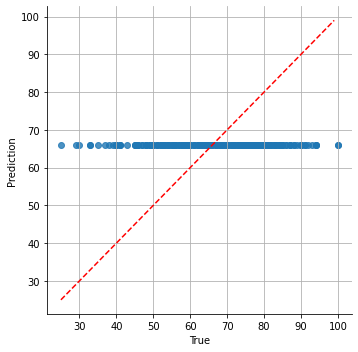

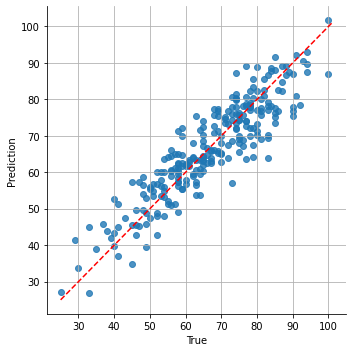

In [24]:
plot_model_results(y_test, y_preds_dummy, title='Dummy')
plot_model_results(y_test, y_preds_lr, title='Linear Regression')

#  Масштабирование и нормализация

In [25]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [26]:
X_train_scaled.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,reading score
0,-0.973680,-0.107697,-0.022284,-0.715609,-0.698638,0.003995
1,1.027032,0.779912,-0.690802,-0.715609,1.431356,1.002853
2,1.027032,-0.995305,-0.690802,1.397410,1.431356,1.069443
3,1.027032,-0.995305,-1.359320,-0.715609,-0.698638,1.269215
4,-0.973680,1.667521,1.983270,1.397410,-0.698638,-0.462138


# Обучение 1

In [27]:
dummy = DummyRegressor(strategy='median')#константное предсказание (медиана)
dummy.fit(X_train_scaled, y_train)
y_preds_dummy = dummy.predict(X_test)

In [28]:
lr = LinearRegression()#бейзлайновая модель (линейная регрессия)
lr.fit(X_train_scaled, y_train)
y_preds_lr = lr.predict(X_test_scaled)

#  Измерение качества 1

In [29]:
print(f'RMSE for Dummy Regressor: {mean_squared_error(y_test, y_preds_dummy, squared=False)}')
print(f'RMSE for Linear Regression: {mean_squared_error(y_test, y_preds_lr, squared=False)}')

RMSE for Dummy Regressor: 14.64226758395024
RMSE for Linear Regression: 6.2947706366015295


In [30]:
print(f'MAPE for Dummy Regressor: {mean_absolute_percentage_error(y_test, y_preds_dummy)}')
print(f'MAPE for Linear Regression: {mean_absolute_percentage_error(y_test, y_preds_lr)}')

MAPE for Dummy Regressor: 0.20459481482418476
MAPE for Linear Regression: 0.08016140211329616


Ошибка уменьшилась незначительно:

RMSE for Linear Regression: 6.294770636601531 (до)

RMSE for Linear Regression: 6.2947706366015295 (после)

MAPE for Linear Regression: 0.08016140211329617 (до)

MAPE for Linear Regression: 0.08016140211329616 (после)